In [ ]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np;
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
import math
import seaborn as sns
import ot
from mpl_toolkits.axes_grid1 import AxesGrid

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [ ]:
# Create neural network architectures

# Define width of neural networks
m = 150
m2 = 100

# Create branch network
class Branch(nn.Module):
    def __init__(self):
        super(Branch, self).__init__()
        # Modify neural network input dimension based on mesh size n (currently 100)
        self.hidden_U = nn.Linear(100,m, bias=True)
        self.hidden_V = nn.Linear(100,m, bias=True)
        self.hidden_H_1 = nn.Linear(100,m, bias=True); self.hidden_Z_1 = nn.Linear(m,m, bias=True)
        self.hidden_Z_2 = nn.Linear(m,m, bias=True); self.hidden_Z_3 = nn.Linear(m,m, bias=True)
        self.hidden_Z_4 = nn.Linear(m,m, bias=True); self.hidden_Z_5 = nn.Linear(m,m, bias=True)
        self.hidden_Z_6 = nn.Linear(m,m, bias=True); self.hidden_Z_7 = nn.Linear(m,800, bias=True)


    def forward(self, u):
        U = F.tanh(self.hidden_U(u)); V = F.tanh(self.hidden_V(u)); H_1 = F.tanh(self.hidden_H_1(u));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output


# Create trunk network
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.hidden_U = nn.Linear(2,m2, bias=True)
        self.hidden_V = nn.Linear(2,m2, bias=True)
        self.hidden_H_1 = nn.Linear(2,m2, bias=True); self.hidden_Z_1 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_2 = nn.Linear(m2,m2, bias=True); self.hidden_Z_3 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_4 = nn.Linear(m2,m2, bias=True); self.hidden_Z_5 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_6 = nn.Linear(m2,m2, bias=True); self.hidden_Z_7 = nn.Linear(m2,800, bias=True)


    def forward(self, x,t):
        z = torch.cat((x,t),1)
        U = F.tanh(self.hidden_U(z)); V = F.tanh(self.hidden_V(z)); H_1 = F.tanh(self.hidden_H_1(z));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output

In [ ]:
# Create neural networks
cty_branch0 = Branch().to(device)
cty_branch1 = Branch().to(device)
cty_trunk = Trunk().to(device)

HJ_branch0 = Branch().to(device)
HJ_branch1 = Branch().to(device)
HJ_trunk = Trunk().to(device)

In [ ]:
# Load in pre-trained neural networks from current directory

File = "Cty_branch0.pth"
cty_branch0.load_state_dict(torch.load(File))

File = "Cty_branch1.pth"
cty_branch1.load_state_dict(torch.load(File))

File = "Cty_trunk.pth"
cty_trunk.load_state_dict(torch.load(File))

File = "HJ_branch0.pth"
HJ_branch0.load_state_dict(torch.load(File))

File = "HJ_branch1.pth"
HJ_branch1.load_state_dict(torch.load(File))

File = "HJ_trunk.pth"
HJ_trunk.load_state_dict(torch.load(File))

In [ ]:
# Define loss functions
mse_cost_function = torch.nn.MSELoss()
l1_cost_function = torch.nn.L1Loss()

In [ ]:
# Create optimizer. Choose initial learning rate at 5e-4 and lower periodically
optimizer = optim.Adam([
    {'params': cty_branch0.parameters()},
    {'params': cty_branch1.parameters()},
    {'params': cty_trunk.parameters()},
    {'params': HJ_branch0.parameters()},
    {'params': HJ_branch1.parameters()},
    {'params': HJ_trunk.parameters()},
], lr=5e-4)

In [ ]:
# Declare univariate normal density value function
def h(x, mu, sigma):
  return (1/(sigma*(2*math.pi)**(1/2)))*(math.e)**((-1/2)*((x-mu)**2)/sigma**2)

In [ ]:
n = 100 # Mesh size
N = 5000 # Number of initial conditions
x_min = 0
x_max = 10
k = 12  # Number of mixtures in u0 and u1 combined
c = 1/6 # Constant for each Gaussian in the mixtures

X = torch.arange(x_min, x_max, (x_max-x_min)/n).to(device)
X_vec = torch.unsqueeze(X,1).to(device)
t0 = torch.zeros(size=(n,1)).to(device)
t1 = torch.ones(size=(n,1)).to(device)

# Create Gaussian mixture data
u0 = torch.zeros(size=(N,n))
u1 = torch.zeros(size=(N,n))
for i in range(N):
  Sigma = np.random.uniform(0.5,0.6,k)
  means = np.random.uniform(2,8,k)
  u0[i,:] = c*h(X, means[0], Sigma[0]) + c*h(X, means[1], Sigma[1]) + c*h(X, means[2], Sigma[2]) + \
            c*h(X, means[3], Sigma[3]) + c*h(X, means[4], Sigma[4]) + c*h(X, means[5], Sigma[5])
  u1[i,:] = c*h(X, means[6], Sigma[6]) + c*h(X, means[7], Sigma[7]) + c*h(X, means[8], Sigma[8]) + \
            c*h(X, means[9], Sigma[9]) + c*h(X, means[10], Sigma[10]) + c*h(X, means[11], Sigma[11])


u0 = u0.to(device)
u1 = u1.to(device)

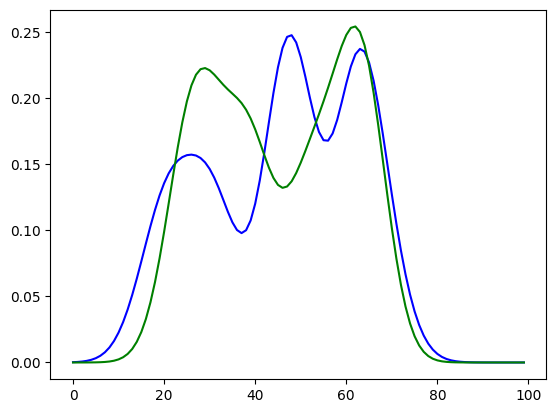

In [ ]:
# Plot Gaussian mixture sample
I = np.random.randint(0,N,1).squeeze()
plt.plot(u0[I,:].cpu().detach().numpy(), color='blue')
plt.plot(u1[I,:].cpu().detach().numpy(), color='green')

In [ ]:
# Create physics-informed loss function for total loss minimization
def physics_informed_loss(x, t, u0, u1, cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk):

  # Feed in data to continuity neural networks
  cty_branch0_output = cty_branch0(u0)
  cty_branch1_output = cty_branch1(u1)
  cty_trunk_output = cty_trunk(x, t)

  # Construct continuity DeepONet with its derivatives
  cty = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output, dim=1)
  cty_x = torch.autograd.grad(cty.sum(), x, create_graph=True)[0]
  cty_t = torch.autograd.grad(cty.sum(), t, create_graph=True)[0]
  cty = torch.unsqueeze(cty,1)

  # Feed in data to Hamilton-Jacobi neural networks
  HJ_branch0_output = HJ_branch0(u0)
  HJ_branch1_output = HJ_branch1(u1)
  HJ_trunk_output = HJ_trunk(x, t)

  # Construct HJ DeepONet with its derivatives
  HJ = torch.sum( (HJ_branch0_output * HJ_branch1_output) * HJ_trunk_output, dim=1)
  HJ_x = torch.autograd.grad(HJ.sum(), x, create_graph=True)[0]
  HJ_xx = torch.autograd.grad(HJ_x.sum(), x, create_graph=True)[0]
  HJ_t = torch.autograd.grad(HJ.sum(), t, create_graph=True)[0]
  HJ = torch.unsqueeze(HJ,1)

  # Compute continuity and HJ residuals
  cty_loss = (cty_t + cty_x*HJ_x + cty*HJ_xx)**2
  HJ_loss = (0.5)*(HJ_t + (1/2)*(HJ_x**2))**2

  # Return physics-informed loss
  return(cty_loss + HJ_loss)

In [ ]:
# Declare number of training iterations and batch size. Recommended to take batch size at least 1000
num_iter = 100000
batch_size = 2000

# Declare a zero vector for evaluating loss terms
T0 = torch.zeros(size=(batch_size,1)).to(device)

# Training algorithm
for i in range(num_iter):

  # Indices for DeepONet evaluation
  I = np.random.randint(0,N,batch_size)
  J = np.random.randint(0,n,batch_size)

  # Collocation procedure
  x_unif = Variable(torch.from_numpy(np.random.uniform(x_min,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  t_unif = Variable(torch.from_numpy(np.random.uniform(0,1,size=(batch_size,1))).float(), requires_grad=True).to(device)

  # Evaluate continuity DeepONets for boundary conditions
  cty_branch0_output = cty_branch0(u0[I,:])
  cty_branch1_output = cty_branch1(u1[I,:])
  cty_trunk_output_0 = cty_trunk(X_vec[J], t0[J])
  cty_trunk_output_1 = cty_trunk(X_vec[J], t1[J])

  # Boundary loss terms
  inner_prod_0 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_0, dim=1)
  inner_prod_1 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_1, dim=1)
  boundary_loss_0 = mse_cost_function(inner_prod_0, u0[I,J])
  boundary_loss_1 = mse_cost_function(inner_prod_1, u1[I,J])

  # Physics-informed terms
  physics_term = physics_informed_loss(x_unif, t_unif, u0[I,:], u1[I,:], cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk)
  physics_loss = l1_cost_function(physics_term, T0)

  # Evaluate the loss
  loss = 1*boundary_loss_0  + 1*boundary_loss_1  + 0.5*physics_loss


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % 100 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), "- PINN loss:", '{:.4e}'.format(physics_loss))

In [ ]:
# Save newly-trained neural networks to current directory

File = "Cty_branch0.pth"
torch.save(cty_branch0.state_dict(), File)

File = "Cty_branch1.pth"
torch.save(cty_branch1.state_dict(), File)

File = "Cty_trunk.pth"
torch.save(cty_trunk.state_dict(), File)

File = "HJ_branch0.pth"
torch.save(HJ_branch0.state_dict(), File)

File = "HJ_branch1.pth"
torch.save(HJ_branch1.state_dict(), File)

File = "HJ_trunk.pth"
torch.save(HJ_trunk.state_dict(), File)

In [ ]:
# Define a heat map plot
def heatmap2d(data: np.ndarray):
  cmap = LinearSegmentedColormap.from_list('Colormap', [ 'orangered', 'darkorange', 'aquamarine', 'dodgerblue', 'blue'])
  fig, (ax) = plt.subplots(1,1, figsize=(4,4))
  ax = sns.heatmap(data, ax=ax, cmap=cmap, square=True, cbar=False)

  ax.set(xticklabels=[]); ax.set(yticklabels=[]); ax.tick_params(left=False, bottom=False)
  plt.savefig("heatmap.png", dpi=300)
  plt.show()

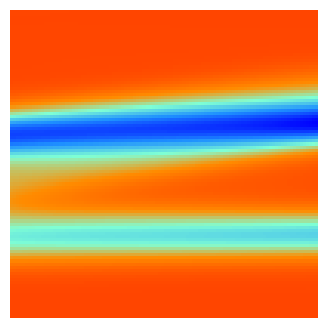

In [ ]:
# Create plot for test pairing

u_test = torch.zeros(size=(n,n))
I = np.random.randint(0,N,1)
J = np.random.randint(0,N,1)

# Compute GeONet geodesic
for i in range(n):
  cty_branch0_output_test = cty_branch0(u0[I,:])
  cty_branch1_output_test = cty_branch1(u1[J,:])
  T_test = 1*(i/(n-1))*torch.ones(size=(n,1)).to(device)
  cty_trunk_output_test = cty_trunk(X_vec, T_test)
  u_test[:,i] = torch.sum( (cty_branch0_output_test * cty_branch1_output_test) * cty_trunk_output_test, dim=1)

heatmap2d(u_test.detach().numpy())

In [ ]:
# Pot algorithm for comparison

T = n
y = np.arange(n, dtype=np.float64)
OT = np.zeros(shape=(n,T))

# Gaussian distributions
a1 = u0[I,:].cpu()
a2 = u1[J,:].cpu()

A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

K = ot.utils.dist0(n)
K /= K.max()

for t in range(T):
  alpha = t/T  # 0<=alpha<=1
  weights = np.array([1 - alpha, alpha])

  # Wasserstein geodesic computation
  reg = 0.0006 # Regularization parameter. Adjust if desired for smoothing
  bary_wass = ot.bregman.barycenter(A, K, reg, weights)

  OT[:,t] = bary_wass

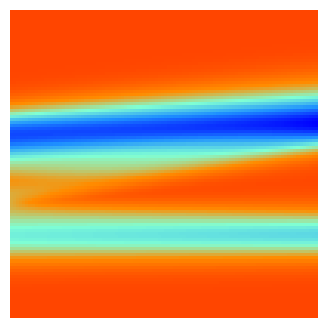

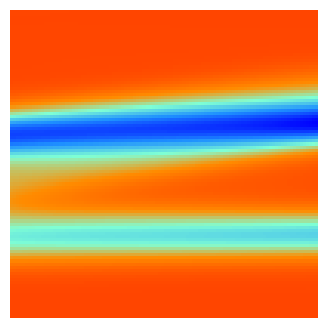

In [ ]:
heatmap2d(OT)

heatmap2d(u_test.detach().numpy())